### Load up required packages

In [12]:
#!/usr/bin/python3
print('##########\nLoading modules...')

import os, sys, getopt, datetime, multiprocessing
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold, cross_validate, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler,label_binarize
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score, plot_confusion_matrix, roc_curve, plot_roc_curve
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, cohen_kappa_score, plot_precision_recall_curve, precision_recall_curve, auc
from sklearn.inspection import permutation_importance
from pickle import load, dump
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap 
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import joblib
import pickle


##########
Loading modules...


### Set working directory and random seed

In [13]:
## set working directory
workdir = os.getcwd()
print('#########\nWorking directory is {}'.format(workdir))

## set seed
np.random.seed(0)


#########
Working directory is /home/Python_code


### Tell program where to look for data

In [14]:
X_path = "../RF_models/model_inputs/microbiome_family.csv"
X_in = pd.read_csv(X_path)
X_in = X_in.sort_index(axis = 0)
#print(X_in.head())
print('\n Dimensions of data are {}'.format(X_in.shape))


 Dimensions of data are (290, 393)


### Tell program what column is the class

In [15]:
y_label= "cluster"
print('\n\nThe class we care about is: **{}**'.format(y_label))
print('Dropping {} from the input data\n'.format(y_label))
y = X_in[[y_label]]
X_in = X_in.drop(y_label, axis=1)



The class we care about is: **cluster**
Dropping cluster from the input data



### Make test train split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X_in, y, random_state = 1, test_size = 0.3, shuffle = True)


### Define the cross validation strategy & pipeline & hyperparameter search space

In [17]:
## inner cross validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

## select k-best features
#feat_sel = SelectKBest(mutual_info_classif)

## pipeline
pipeline_rf = Pipeline([
    #('mutual_info', feat_sel),
    ('model', RandomForestClassifier(random_state=1, oob_score=True, class_weight='balanced'))
        ])

In [18]:
## define the hyperparameter search space
space = dict()
space['model__n_estimators'] = np.arange(500,1500,50)
space['model__min_samples_split'] = np.arange(2,5,1)
space['model__max_features'] = np.arange(0.2,0.8,0.05)
space['model__max_samples'] = np.arange(0.1, 1, 0.05)
#space['model__criterion'] = ['gini', 'entropy']
#space['mutual_info__k'] = np.arange(10, 360, 20)

### Tune the hyperparmeters with RandomizedSearchCV

In [ ]:
scoring = {'f1_macro','balanced_accuracy'} 
refit = 'balanced_accuracy'
search = RandomizedSearchCV(estimator = pipeline_rf, n_iter=2000, 
                      param_distributions = space, scoring=scoring, 
                      cv=cv, refit=refit, return_train_score = True, n_jobs = 24, random_state=1)
search.fit(x_train, y_train.values.ravel())

In [19]:
## OR load up previously saved file
with open('../RF_models/microbiome_family.pkl', 'rb') as f:
    search = pickle.load(f)

rf_final_pipe = search.best_estimator_
print("Best model:\n", search.best_estimator_)
print("Best params:\n", search.best_params_)
search.best_estimator_.fit(x_train, y_train)

Best model:
 Pipeline(steps=[('model',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features=0.7,
                                        max_samples=0.9500000000000003,
                                        min_samples_split=7, n_estimators=1100,
                                        oob_score=True, random_state=1))])
Best params:
 {'model__n_estimators': 1100, 'model__min_samples_split': 7, 'model__max_samples': 0.9500000000000003, 'model__max_features': 0.7}


Pipeline(steps=[('model',
                 RandomForestClassifier(class_weight='balanced',
                                        max_features=0.7,
                                        max_samples=0.9500000000000003,
                                        min_samples_split=7, n_estimators=1100,
                                        oob_score=True, random_state=1))])

### Analyze performance of classifier

OOB score: 0.6206896551724138
Balanced Accuracy: 0.4236111111111111
f1_score (macro): 0.3529597974042418
Cohen's kappa: 0.17769376181474472


ValueError: Pipeline should be a binary classifier

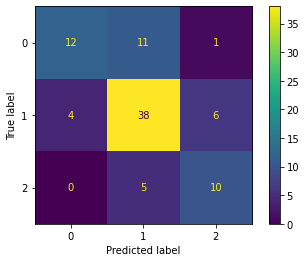

In [20]:
## plot the confusion matrix on the test data
plot_confusion_matrix(rf_final_pipe, x_test, y_test)

## print OOB score on test data
print("OOB score:",search.best_estimator_.named_steps['model'].oob_score_)

## print balanced accuracy score on test data
## The balanced accuracy in binary and multiclass classification problems 
## to deal with imbalanced datasets. It is defined as the average of recall obtained on each class. 
yhat = rf_final_pipe.predict_proba(x_test)
preds = [1 if yhat[i][1] > .5 else 0 for i in range(len(yhat))]
print("Balanced Accuracy:", balanced_accuracy_score(y_test, preds))

## print the F1-score (mix between precision and recall)
print("f1_score (macro):", f1_score(y_test, preds, average='macro'))

## print the Cohen Kappa score
print("Cohen's kappa:", cohen_kappa_score(y_test, preds))

## plot roc curve
plot_roc_curve(rf_final_pipe, x_test, y_test)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

## plot pr curve
plot_precision_recall_curve(rf_final_pipe, x_test, y_test)
precision, recall, _ = precision_recall_curve(y_test, preds)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

## roc curve: multiclass
#print("ROC AUC:", roc_auc_score(y_test, yhat, multi_class='ovr', average='weighted'))

## roc curve: binary
print("ROC AUC:", roc_auc_score(y_test, yhat[:,1]))

## classification report
print(classification_report(y_test, preds))

### Modify probabilities due to class imbalance

In [80]:
# determine a new cutoff for classification (not 0.5 anymore!)
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
probs = yhat[:, 1]
thresholds = np.arange(0,1,0.001)

## use Cohen's Kappa (or F1 or ROC AUC or Balanced Accuracy)
#scores = [f1_score(y_test, to_labels(probs, t), average='macro') for t in thresholds]
#scores = [balanced_accuracy_score(y_test, to_labels(probs, t)) for t in thresholds]
#scores = [roc_auc_score(y_test, to_labels(probs, t)) for t in thresholds]
scores = [cohen_kappa_score(y_test, to_labels(probs, t)) for t in thresholds]

In [81]:
## Figure out the highest score for all probability thresholds (0-1)
ix = np.argmax(scores)
print(f'Threshold = {thresholds[ix]}, Kappa = {scores[ix]}')
new_threshold = thresholds[ix]

Threshold = 0.6940000000000001, Kappa = 0.466512702078522


In [82]:
## Change the probability threshold
new_preds = [1 if yhat[i][1] > new_threshold else 0 for i in range(len(yhat))]
print(new_preds)

[0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1]


In [83]:
## Analyze classifier performance with new probability threshold
print("New Confusion Matrix:\n", confusion_matrix(y_test, new_preds))
print("f1_score (macro):", f1_score(y_test, new_preds, average='macro'))
print("Balanced Accuracy:", f1_score(y_test, new_preds))
print("ROC AUC:", roc_auc_score(y_test, new_preds))
print("Cohen's Kappa:", cohen_kappa_score(y_test, new_preds))
precision, recall, _ = precision_recall_curve(y_test, new_preds)
auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)


New Confusion Matrix:
 [[11  2]
 [ 9 20]]
f1_score (macro): 0.7254901960784315
Balanced Accuracy: 0.7843137254901961
ROC AUC: 0.7679045092838196
Cohen's Kappa: 0.466512702078522
PR AUC: 0.907


### Analyze Feature Importance: SHAP values

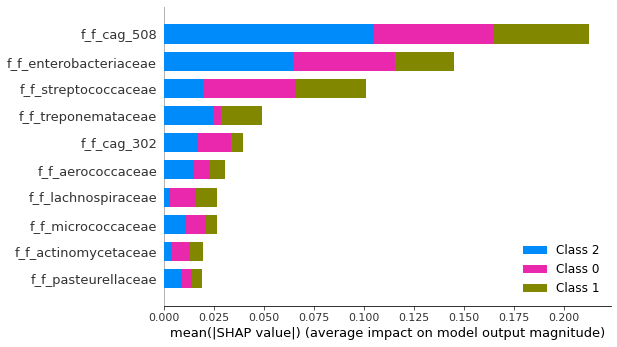

In [21]:
# Print out shap values
shap_values = shap.TreeExplainer(rf_final_pipe['model']).shap_values(X_in)
shap.summary_plot(shap_values, X_in, plot_type="bar", max_display=10, show=False)
#plt.savefig('/home/Figures/shap_figures/diet_life_New_covariates.pdf',format='pdf', dpi=1000, bbox_inches='tight')
#plt.clf()
#shap.summary_plot(shap_values[1], X_in, plot_type = 'dot', max_display= 20, show=False)
#plt.savefig('/home/Figures/shap_figures/diet-lifestyle_input_bi_f1_400iter.pdf',format='pdf', dpi=1000, bbox_inches='tight')
#plt.clf()



































































































































































































































































































































































































































































### Output raw shap values

In [ ]:
def get_transformer_feature_names(columnTransformer):

    output_features = []

    for name, pipe, features in columnTransformer.transformers_:
        if name!='remainder':
            for i in pipe:
                trans_features = []
                if hasattr(i,'categories_'):
                    trans_features.extend(i.get_feature_names(features))
                else:
                    trans_features = features
            output_features.extend(trans_features)

    return output_features

#transform the x data 
mod = rf_final_pipe['model']

preds = mod.predict_proba(X_in)
feature_names = X_in.columns
print(feature_names)
shap_values = shap.TreeExplainer(mod).shap_values(X_in)
explainer = shap.TreeExplainer(mod)

##row sums for subj 0 
print(shap_values[0][0].sum(0))

print(preds[0,0]) #this is the prediction for subj 0, class 0 
print(explainer.expected_value[0]) #expected valuef or class 0
print(preds[0,0] - explainer.expected_value[0]) #the diff between the model output and the expected value. should match the above value


shap_values0 = pd.DataFrame(shap_values[0], columns = feature_names, index = X_in.index)
shap_values1 = pd.DataFrame(shap_values[1], columns = feature_names, index = X_in.index)
#shap_values2 = pd.DataFrame(shap_values[2], columns = feature_names, index = X_in.index)

#print(list(shap_values0.columns))

#file0 = "diet-life_high-low_shapvals-NEW.csv"
file1 = "diet-life_high-low_shapvals-NEW.csv"
#file2 = "diet-life_high-low_class2_shapvals-NEW.csv"
#file_raw = "diet-life_bi_raw-NEW.csv"
#file2 = "diet-life_input_bi_class2_shapvals.csv"
#path = "../machine_learning/new_dataset_models/shap_values/"

path = ""
#shap_values0.to_csv(path + file0, index = True)
shap_values1.to_csv(path + file1, index = True)
#shap_values2.to_csv(path + file2, index = True)
#X_in.to_csv(path + file_raw, index = True)


### Save model as pickle file

In [ ]:
## save CHECK FILE NAME!!
#import pickle
#with open('diet_life_high-low.pkl','wb') as f:
#    pickle.dump(search,f)


In [ ]:
for col in X_in.columns:
    print(col)

### Run the data through DUMMY classifier

In [ ]:
## running the dummy classifier
clf_dummy = DummyClassifier(random_state=1, strategy='most_frequent')
dummy_fit = clf_dummy.fit(x_train, y_train)
y_pred_dummy = clf_dummy.predict(x_test)

## Analyze dummy classifier performance with new probability threshold
print("New Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dummy))
print("f1_score (macro):", f1_score(y_test, y_pred_dummy, average='macro'))
print("Balanced Accuracy:", f1_score(y_test, y_pred_dummy))
print("ROC AUC:", roc_auc_score(y_test, y_pred_dummy, average= 'weighted'))
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred_dummy))

## plot roc curve
plot_roc_curve(dummy_fit, x_test, y_test)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

## plot the confusion matrix on the test data
plot_confusion_matrix(dummy_fit, x_test, y_test)

## roc curve: multiclass
#print("ROC AUC:", roc_auc_score(y_test, y_pred_dummy, multi_class='ovr', average='weighted'))

## pr curve
plot_precision_recall_curve(dummy_fit, x_test, y_test, pos_label=1)
precision, recall, _ = precision_recall_curve(y_test, y_pred_dummy)
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score)